In [495]:
import numpy as np
import scipy as sp
import sympy
import math
import matplotlib.pyplot as plt
from closed_circuit import *
from p_tqdm import p_map
import pandas as pd

In [2]:
def dydt(t,y, params):
    C_p, Za_p, R_p = params
    cap_p = PressureSystem(C_p, Za_p, R_p)
    
    v_lv = y[0]
    v_la = y[1]
    q_av = y[2]
    q_mv = y[3]
    xi_av = y[4]
    xi_mv = y[5]
    #pressure of capillaries in systemic circulation
    pa = y[6]
    v_rv = y[7]
    v_ra = y[8]
    q_tv = y[9]
    q_pv = y[10]
    xi_tv = y[11]
    xi_pv = y[12]
    #pressure of capillaries in pulmonary circulation
    pb = y[13]
    
    #calculate parameters
    #systemic
    p_la = la.p(v_la,t)
    p_lv = lv.p(v_lv,t)
    #p_aa: pressure at the coupling point of av and capillaries
    p_aa = cap_s.pi(q_av,pa)
    #pulmonary
    p_ra = ra.p(v_ra,t)
    p_rv = rv.p(v_rv,t)
    #q_cap2: flow out the capillaries of pulmonary circulation
    q_cap2 = cap_p.qout(pb,p_la)
    #p_pa: pressure at the coupling point of pv and capillaries
    p_pa = cap_p.pi(q_tv,pb)
    #q_cap1: flow out the capillaries of systemic circulation
    q_cap1 = cap_s.qout(pa,p_ra)
    
    #derivative
    #la
    dv_la = la.dv(t,v_la,q_cap2,q_mv)
    dxi_mv = mv.dxi(t,xi_mv,p_la,p_lv)
    dq_mv = mv.dq(t,q_mv,xi_mv,p_la,p_lv)
    #lv
    dv_lv = lv.dv(t,v_lv,q_mv,q_av)
    dxi_av = av.dxi(t,xi_av,p_lv,p_aa)
    dq_av = av.dq(t,q_av,xi_av,p_lv,p_aa)
    #cap sys
    dpa = cap_s.dp_original(t,pa,q_av,p_ra)
    #ra
    dv_ra = ra.dv(t,v_ra,q_cap1,q_tv)
    dxi_tv = tv.dxi(t,xi_tv,p_ra,p_rv)
    dq_tv = tv.dq(t,q_tv,xi_tv,p_ra,p_rv)
    #rv
    dv_rv = rv.dv(t,v_rv,q_tv,q_pv)
    dxi_pv = pv.dxi(t,xi_pv,p_rv,p_pa)
    dq_pv = pv.dq(t,q_pv,xi_pv,p_rv,p_pa)
    #cap pul
    dpb = cap_p.dp_original(t,pb,q_pv,p_la)
    
    #derivative vector
    dy = np.array([dv_lv, dv_la, 
                   dq_av, dq_mv, 
                   dxi_av, dxi_mv, 
                   dpa, 
                   dv_rv, dv_ra, 
                   dq_tv, dq_pv, 
                   dxi_tv, dxi_pv, 
                   dpb])
    return dy

In [3]:
def ODE(params):
    C_p, Za_p, R_p = params
    cap_p = PressureSystem(C_p, Za_p, R_p)
    y_initial = np.array([135, 27, #lv, la
                      150, 10, #qav, qmv
                      0.01, 0.5, #xi_av, xi_mv
                      5*1333, #pa
                      180, 40, #v_rv, v_ra 
                      150, 10, #q_tv, q_pv
                      0.01, 0.5, #xi_tv, xi_pv
                      5*1333]) # pb
    sol = sp.integrate.solve_ivp(dydt , t , y0 = y_initial , t_eval = t_span, method='LSODA', args = [params])
    sol.t = sol.t[int(T*1000):int(T*1100)]
    v_lv = sol.y[0][int(T*1000):int(T*1100)]
    v_la = sol.y[1][int(T*1000):int(T*1100)]
    q_av = sol.y[2][int(T*1000):int(T*1100)]
    q_mv = sol.y[3][int(T*1000):int(T*1100)]
    xi_av = sol.y[4][int(T*1000):int(T*1100)]
    xi_mv = sol.y[5][int(T*1000):int(T*1100)]
    pa = sol.y[6][int(T*1000):int(T*1100)]
    v_rv = sol.y[7][int(T*1000):int(T*1100)]
    v_ra = sol.y[8][int(T*1000):int(T*1100)]
    q_tv = sol.y[9][int(T*1000):int(T*1100)]
    q_pv = sol.y[10][int(T*1000):int(T*1100)]
    xi_tv = sol.y[11][int(T*1000):int(T*1100)]
    xi_pv = sol.y[12][int(T*1000):int(T*1100)]
    pb = sol.y[13][int(T*1000):int(T*1100)]
    
    p_lv, p_rv, p_la, p_ra, p_ao, p_pa = [], [], [], [], [], []
    for i,j in zip(sol.t,range(len(sol.t))):
        p_lv.append(lv.p(v_lv[j], i))
        p_la.append(la.p(v_la[j], i))
        p_ra.append(ra.p(v_ra[j], i))
        p_rv.append(rv.p(v_rv[j], i))
        p_ao.append(cap_s.pi(q_av[j], pa[j]))
        p_pa.append(cap_p.pi(q_pv[j], pb[j]))
    p_lv, p_rv, p_ao, p_pa, p_la, p_ra= np.array(p_lv)/1333, np.array(p_rv)/1333, np.array(p_ao)/1333, np.array(p_pa)/1333, np.array(p_la)/1333, np.array(p_ra)/1333
    return p_lv, p_rv, p_ao, p_pa, p_la, p_ra, v_lv, v_la, v_rv, v_ra, q_av, q_mv, q_tv, q_pv, xi_av, xi_mv, xi_tv, xi_pv

In [4]:
def data_processing(v_lv, v_rv, p_lv, p_rv, p_ao):
    max_volume_rv = max(v_rv)
    min_volume_rv = min(v_rv)
    sv_rv = max_volume_rv - min_volume_rv
    rvef = sv_rv / max_volume_rv
    max_volume_lv = max(v_lv)
    
    min_volume_lv = min(v_lv)
    sv_lv = max_volume_lv - min_volume_lv
    lvef = sv_lv / max_volume_lv
    return sv_rv, sv_lv, rvef, lvef

In [5]:
def err_cal(params):
    err = []
    for i in range(len(params)):
        diff = (params[i] - params[0])/params[0]
        err.append(diff*100)
    err = np.array(err)
    return err

In [453]:
def bar_fig(ax, model, color, *args):
    positions = []
    labels = [str(i) for i in range(len(model))]
    colors = [original] * len(model)
    color_backup = color
    for i, value in enumerate(args):
        if model[1] > model[0]:
            insert_position = np.searchsorted(model, value)
        else:
            insert_position = np.searchsorted(model[::-1], value, side='right')
            insert_position = len(model) - insert_position
        
        labels = np.insert(labels, insert_position, f'C{i+1}')
        model = np.insert(model, insert_position, value)
        colors = np.insert(colors, insert_position, color_backup[i])
        positions.append(insert_position)
    ip = int(np.mean(positions))
    if ip < 2:
        start_index = max(0, ip - 3)
        end_index = min(len(model), ip + 4)
    else:
        ip_min = np.min(positions)
        ip_max = np.max(positions)
        if ip_min == 0:
            start_index = 0
            end_index = ip_max+3
        else:
            start_index = ip_min - 1
            end_index = ip_max + 2
        if len(model[start_index:end_index]) < 6:
            start_index = ip - 4
            end_index = ip + 4
    
    model = model[start_index:end_index]
    labels = labels[start_index:end_index]
    colors = colors[start_index:end_index]

    ax.bar(labels, model, color=colors)

In [508]:
def cal_meansd(pre, pod2, key):
    key_value = []
    sd = []
    mean = []
    for i in range(len(pre)):
        key_value.append(pre[i][key])
    sd.append(np.std(key_value,ddof=0))
    mean.append(np.mean(key_value))
    key_value = []
    for i in range(len(pod2)):
        key_value.append(pod2[i][key])
    sd.append(np.std(key_value,ddof=0))
    mean.append(np.mean(key_value))
    return mean,sd

In [213]:
T = 0.8
lv=heart(tau1 = 0.269*T, tau2 = 0.452*T, m1 = 1.32, m2 = 27.4, Emax = 3, Emin = 0.08, V0 = 10,T = T, deltat = 0.01)# V0 (mL), T (s)
la=heart(tau1 = 0.110*T, tau2 = 0.180*T, m1 = 1.32, m2 = 13.1, Emax = 0.17, Emin = 0.08,V0 = 3,T = T, deltat = 0.01, delay = 0.85*T) # V0 (mL), T (s)
rv=heart(tau1 = 0.269*T, tau2 = 0.452*T, m1 = 1.32, m2 = 27.4, Emax = 0.8, Emin = 0.04, V0 = 10, T = T, deltat = 0.01) # Ks, V0 ,T
ra=heart(tau1 = 0.110*T, tau2 = 0.180*T, m1 = 1.32, m2 = 13.1, Emax = 0.15, Emin = 0.04, V0 = 3, T = T, deltat = 0.01, delay = 0.85*T) # Ks, V0, T
av=ValveinP(density = 1.06, eff_length = 2.2,Aann = 5, Kvo = 0.12,Kvc = 0.15, p_oc = 0)
mv=ValveinP(density = 1.06,eff_length =1.9,Aann = 5, Kvo = 0.3,Kvc = 0.4, p_oc = 0)
tv=ValveinP(1.06,2,6, 0.3,0.4, 0) #poc (mmHg)
pv=ValveinP(1.06,1.9,2.8, 0.2,0.2, 0) #poc

data = np.array([
 0.00061      , 103.44867    , 1471.26289  , 0.00272      , 26.64387     , 165.27640 
])
C_s, Za_s, R_s, C_p, Za_p, R_p = data[0], data[1], data[2], data[3], data[4], data[5]
cap_s=PressureSystem(C_s, Za_s, R_s)
cap_p=PressureSystem(C_p, Za_p, R_p)
t_end=10
t = [0,t_end]
t_step = 0.01
t_span=np.arange(0,t_end,t_step)
index_range = slice(int(1000*T), int(1100*T))

In [214]:
input_para = [[0.00272, 26.64387, 165.27640 ]]
labels = [' Healthy']
rm = [0]
for n in np.arange(1,18,1):
    pul_cir = lumped_resection_unified(C = cap_p.C, Za = cap_p.Za, R = cap_p.R, n = n, N =19)
    R = pul_cir.updated_R()
    Za = pul_cir.updated_Za()
    C = pul_cir.updated_C()
    input_para.append([C, Za, R])
    labels.append('{} Seg(s) Res. '.format(n))
    rm.append(n)
input_para = np.array(input_para)

In [215]:
results = np.array(p_map(ODE, input_para, num_cpus = 32))
p_lv = results[:, 0]
p_rv = results[:, 1]
p_pa = results[:, 3]
v_rv = results[:, 8]
v_lv = results[:, 6]
p_ao = results[:, 2]
results = np.array(p_map(data_processing, v_lv, v_rv, p_lv, p_rv, p_ao, num_cpus = 32))
sv_rv, sv_lv, rvef, lvef = results[:, 0], results[:, 1], results[:, 2], results[:, 3]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 744.10it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


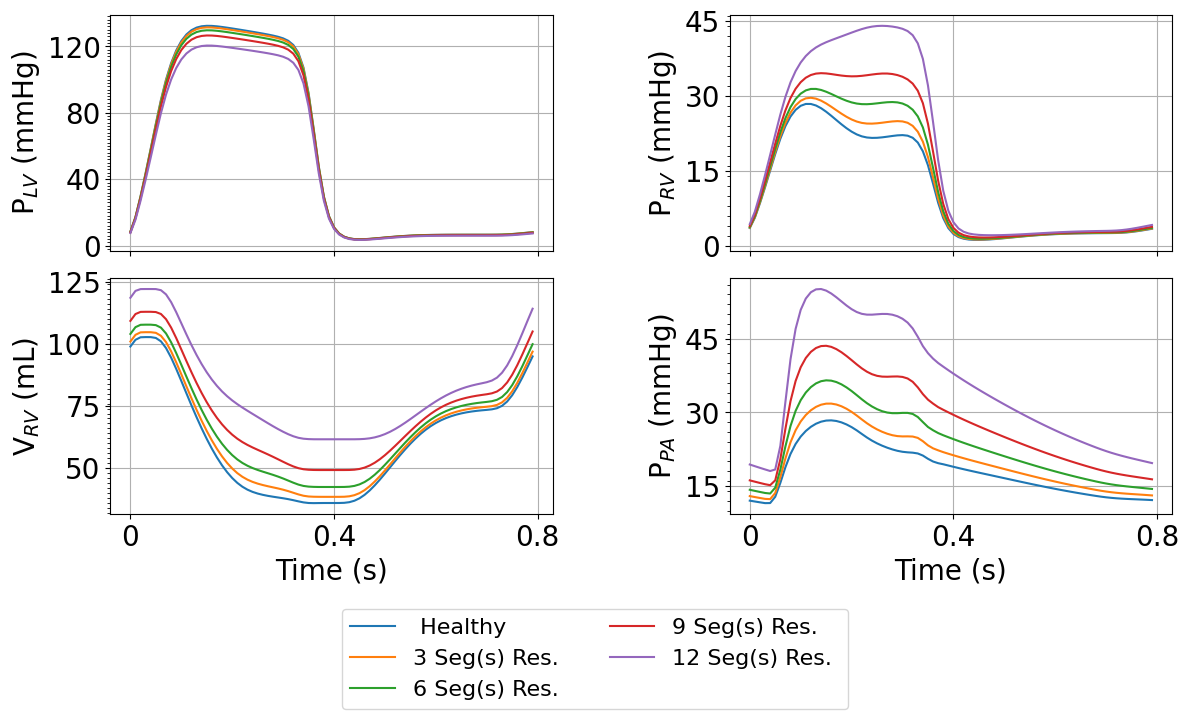

In [489]:
t = np.arange(0,0.8,0.01)
fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
custom_ticks = [0, 0.4, 0.8]  # 自定义刻度位置
# 第一张图
for i, j in zip(range(0, 13, 3), range(0, 13, 3)):
    axs[0,0].plot(t, p_lv[i], label=labels[j])
axs[0,0].set_ylabel(r'P$_{LV}$ (mmHg)', fontsize = fontsize)
axs[0,0].grid(True)
axs[0,0].tick_params(axis='both', which='major', labelsize=20)
axs[0, 0].set_xticks(custom_ticks)
axs[1,0].set_xlabel('Time (s)', fontsize = fontsize)
axs[0, 0].set_xticklabels(custom_ticks, fontsize=15)
# 第二张图
for i, j in zip(range(0, 13, 3), range(0, 13, 3)):
    axs[0,1].plot(t, p_rv[i])
axs[0,1].set_ylabel(r'P$_{RV}$ (mmHg)', fontsize = fontsize)
axs[0,1].grid(True)
axs[0,1].tick_params(axis='both', which='major', labelsize=20)
# 第三张图
for i, j in zip(range(0, 13, 3), range(0, 13, 3)):
    axs[1,0].plot(t, v_rv[i])
axs[1,0].set_ylabel(r'V$_{RV}$ (mL)', fontsize = fontsize)
axs[1,0].grid(True)
axs[1,0].tick_params(axis='both', which='major', labelsize=20)
# 第四张图
for i, j in zip(range(0, 13, 3), range(0, 13, 3)):
    axs[1,1].plot(t, p_pa[i])
axs[1,1].set_ylabel(r'P$_{PA}$ (mmHg)', fontsize = fontsize)
axs[1,1].set_xlabel('Time (s)', fontsize = fontsize)
axs[1,1].legend()
axs[1,1].grid(True)
axs[1,1].tick_params(axis='both', which='major', labelsize=20)
# 调整布局
plt.tight_layout()
for ax in axs.flat:
    ax.tick_params(axis = 'x', labelsize = fontsize)
    ax.tick_params(axis = 'y', labelsize = fontsize)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4,  integer=True))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))

for ax in axs.flat:
    ax.legend().set_visible(False)
fig.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.2), fontsize=16)
plt.subplots_adjust(wspace = 0.4)
# 保存图片
plt.savefig('cardiac_pressure.svg', format='svg', bbox_inches='tight')
plt.savefig('cardiac_pressure.pdf', format='pdf', bbox_inches='tight')
plt.show()

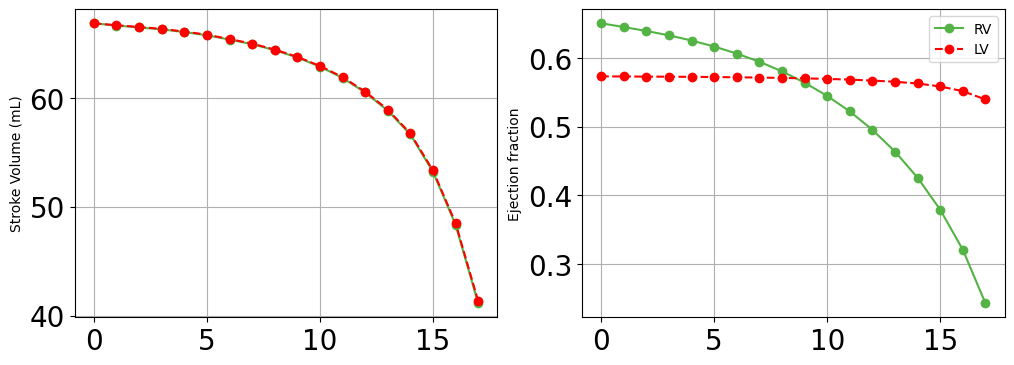

In [11]:
t = np.arange(0,0.8,0.01)
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
custom_ticks = [0, 5, 10,15]  # 自定义刻度位置
# 第一张图
axs[0].plot(rm, sv_rv, marker='o', linestyle='-', color='#54B345', label = 'RV')
axs[0].plot(rm, sv_lv, marker='o', linestyle='--', color='r', label = 'LV')
axs[0].set_ylabel('Stroke Volume (mL)')
axs[0].grid(True)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_xticks(custom_ticks)
axs[0].set_xticklabels(custom_ticks, fontsize=20)
# 第二张图

axs[1].plot(rm, rvef, marker='o', linestyle='-', color='#54B345', label='RV')
axs[1].plot(rm, lvef, marker='o', linestyle='--', color='r', label='LV')
axs[1].set_ylabel('Ejection fraction')
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_xticks(custom_ticks)
axs[1].grid(True)
plt.legend()
#plt.savefig('cardiac_function.svg')
plt.show()

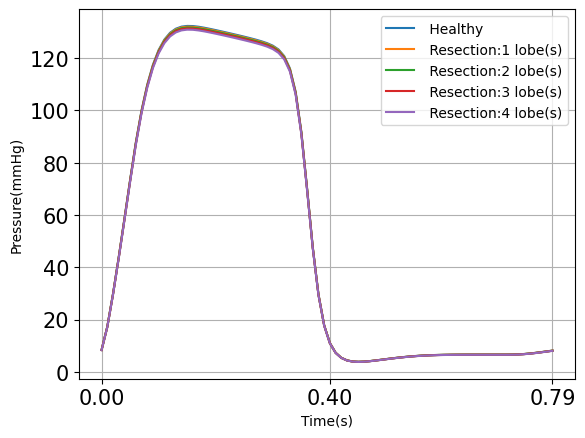

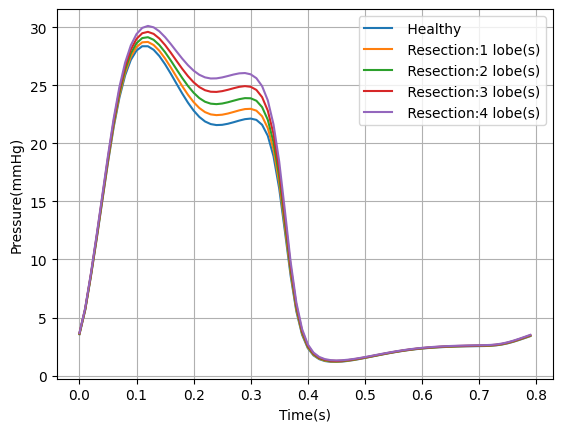

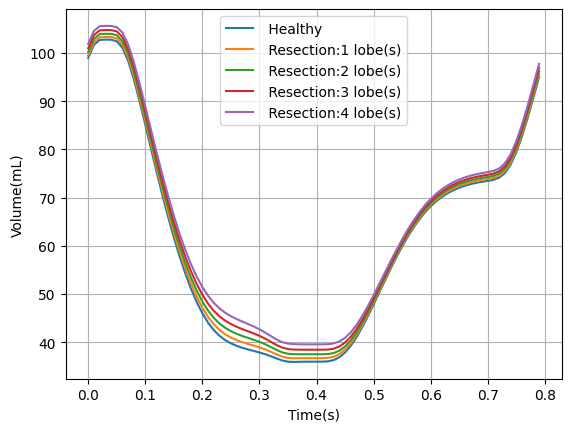

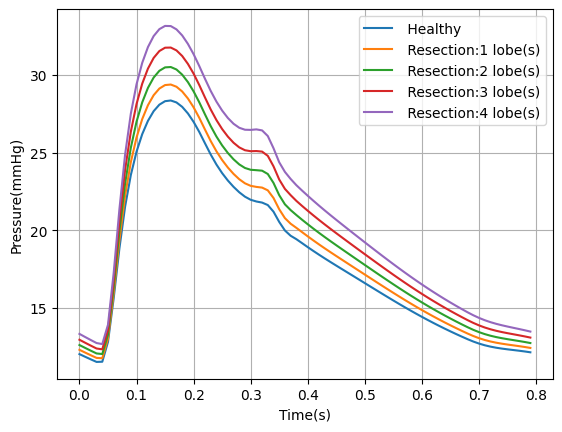

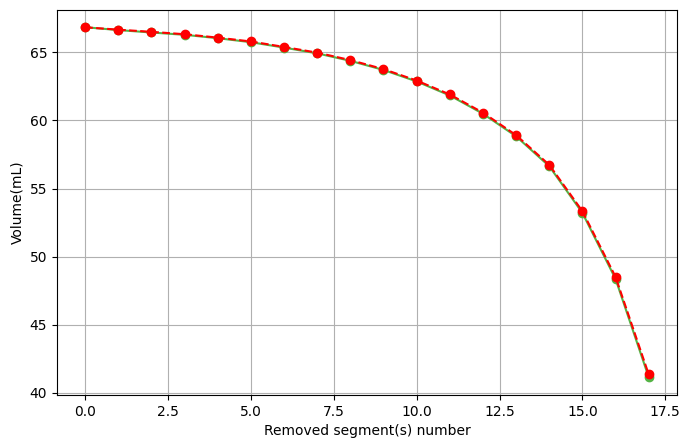

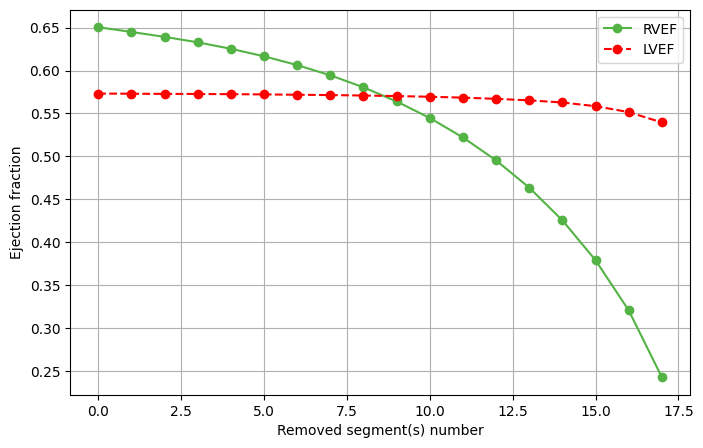

In [12]:
t = np.arange(0,0.8,0.01)
for i,j in zip(range(p_lv.shape[0]), range(0,5)):
    plt.plot(t, p_lv[i], label = labels[j])
    plt.legend()
plt.grid()
plt.ylabel('Pressure(mmHg)')
plt.xlabel('Time(s)')
plt.xticks(ticks=[t[0], t[len(t)//2], t[-1]], fontsize=15)  # 仅显示3个刻度
plt.yticks(fontsize=15)
plt.savefig('p_lv.svg')
plt.show()

for i,j in zip(range(p_lv.shape[0]), range(0,5)):
    plt.plot(t, p_rv[i], label = labels[j])
    plt.legend()
plt.grid()
plt.ylabel('Pressure(mmHg)')
plt.xlabel('Time(s)')
plt.savefig('p_rv.svg')
plt.show()

for i,j in zip(range(p_lv.shape[0]), range(0,5)):
    plt.plot(t, v_rv[i], label = labels[j])
    plt.legend()
plt.grid()
plt.ylabel('Volume(mL)')
plt.xlabel('Time(s)')
plt.savefig('v_rv.svg')
plt.show()

for i,j in zip(range(p_lv.shape[0]), range(0,5)):
    plt.plot(t, p_pa[i], label = labels[j])
    plt.legend()
plt.grid()
plt.ylabel('Pressure(mmHg)')
plt.xlabel('Time(s)')
plt.savefig('p_pa.svg')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(rm, sv_rv, marker='o', linestyle='-', color='#54B345', label = 'SVRV')
plt.plot(rm, sv_lv, marker='o', linestyle='--', color='r', label = 'SVLV')
plt.xlabel("Removed segment(s) number")
plt.ylabel("Volume(mL)")
plt.grid(True)
plt.savefig('sv.svg')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(rm, rvef, marker='o', linestyle='-', color='#54B345', label='RVEF')
plt.plot(rm, lvef, marker='o', linestyle='--', color='r', label='LVEF')
plt.xlabel("Removed segment(s) number")
plt.ylabel("Ejection fraction")
plt.legend()
plt.grid(True)
plt.savefig('ef.svg')
plt.show()

In [533]:
xaxis = range(0,18)

In [496]:
preop = 'pre-op.xlsx'
pod2 = 'pod2.xlsx'
preop = pd.read_excel(preop)
pod2 = pd.read_excel(pod2)

In [521]:
preop_3 = []
pod2_3 = []
preop_4 = []
pod2_4 = []
preop_5 = []
pod2_5 = []
preop_9 = []
pod2_9 = []
seg_3 = [3,4,7,8,10,16,20,25,26,27]
seg_4 = [15, 24]
seg_5 = [1, 2,5,9,11,12,13,14,17,18,21,22,23,28]
seg_9 = [6]
for index, row in preop.iterrows():
    if row[0] in seg_3:
        preop_3.append(row)
    if row[0] in seg_4:
        preop_4.append(row)
    if row[0] in seg_5:
        preop_5.append(row)
    if row[0] in seg_9:
        preop_9.append(row)    
for index, row in pod2.iterrows():
    if row[0] in seg_3:
        pod2_3.append(row)
    if row[0] in seg_4:
        pod2_4.append(row)
    if row[0] in seg_5:
        pod2_5.append(row)
    if row[0] in seg_9:
        pod2_9.append(row)

/tmp/ipykernel_594004/1658074931.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0] in seg_3:
/tmp/ipykernel_594004/1658074931.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0] in seg_4:
/tmp/ipykernel_594004/1658074931.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0] in seg_5:
/tmp/ipykernel_594004/1658074931.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In

In [522]:
rvedv_3m, rvedv_3sd = cal_meansd(preop_3, pod2_3, 'RVEDV')
rvesv_3m, rvesv_3sd = cal_meansd(preop_3, pod2_3, 'RVESV')
rvsv_3m, rvsv_3sd = cal_meansd(preop_3, pod2_3, 'RVSV')
rvef_3m, rvef_3sd = cal_meansd(preop_3, pod2_3, 'RVEF')

rvedv_4m, rvedv_4sd = cal_meansd(preop_4, pod2_4, 'RVEDV')
rvesv_4m, rvesv_4sd = cal_meansd(preop_4, pod2_4, 'RVESV')
rvsv_4m, rvsv_4sd = cal_meansd(preop_4, pod2_4, 'RVSV')
rvef_4m, rvef_4sd = cal_meansd(preop_4, pod2_4, 'RVEF')

rvedv_5m, rvedv_5sd = cal_meansd(preop_5, pod2_5, 'RVEDV')
rvesv_5m, rvesv_5sd = cal_meansd(preop_5, pod2_5, 'RVESV')
rvsv_5m, rvsv_5sd = cal_meansd(preop_5, pod2_5, 'RVSV')
rvef_5m, rvef_5sd = cal_meansd(preop_5, pod2_5, 'RVEF')

rvedv_9m, rvedv_9sd = cal_meansd(preop_9, pod2_9, 'RVEDV')
rvesv_9m, rvesv_9sd = cal_meansd(preop_9, pod2_9, 'RVESV')
rvsv_9m, rvsv_9sd = cal_meansd(preop_9, pod2_9, 'RVSV')
rvef_9m, rvef_9sd = cal_meansd(preop_9, pod2_9, 'RVEF')

lvedv_3m, lvedv_3sd = cal_meansd(preop_3, pod2_3, 'LVEDV')
lvesv_3m, lvesv_3sd = cal_meansd(preop_3, pod2_3, 'LVESV')
lvsv_3m, lvsv_3sd = cal_meansd(preop_3, pod2_3, 'LVSV')
lvef_3m, lvef_3sd = cal_meansd(preop_3, pod2_3, 'LVEF')

lvedv_4m, lvedv_4sd = cal_meansd(preop_4, pod2_4, 'LVEDV')
lvesv_4m, lvesv_4sd = cal_meansd(preop_4, pod2_4, 'LVESV')
lvsv_4m, lvsv_4sd = cal_meansd(preop_4, pod2_4, 'LVSV')
lvef_4m, lvef_4sd = cal_meansd(preop_4, pod2_4, 'LVEF')

lvedv_5m, lvedv_5sd = cal_meansd(preop_5, pod2_5, 'LVEDV')
lvesv_5m, lvesv_5sd = cal_meansd(preop_5, pod2_5, 'LVESV')
lvsv_5m, lvsv_5sd = cal_meansd(preop_5, pod2_5, 'LVSV')
lvef_5m, lvef_5sd = cal_meansd(preop_5, pod2_5, 'LVEF')

lvedv_9m, lvedv_9sd = cal_meansd(preop_9, pod2_9, 'LVEDV')
lvesv_9m, lvesv_9sd = cal_meansd(preop_9, pod2_9, 'LVESV')
lvsv_9m, lvsv_9sd = cal_meansd(preop_9, pod2_9, 'LVSV')
lvef_9m, lvef_9sd = cal_meansd(preop_9, pod2_9, 'LVEF')

In [526]:
rvedv_3 = 0.688986738
rvesv_3 = 9.735956419

rvsv_3 = -5.760396498

rvef_3 = -6.26035845

lvedv_3 = -3.683212412

lvesv_3 = -7.125831927

lvsv_3 = 1.71627596

lvef_3 = 5.992470545

rvedv_4 = -4.297022239

rvesv_4 =-2.549342105

rvsv_4 = -5.77592206


rvef_4 = -1.545301782

lvedv_4 = 4.063678257

lvesv_4 = 23.94504416

lvsv_4 = -10.74561404

lvef_4 = -14.23099062

rvedv_5= 9.030293783


rvesv_5 =24.08044042


rvsv_5 = -2.128491553



rvef_5 = -10.13460377


lvedv_5 = -2.478339683


lvesv_5 = 4.780329583


lvsv_5= -7.204626374


lvef_5 = -3.909626338


In [596]:
def bar(axs, color, model, **kwargs):
    for key, value in kwargs.items():
        if key == 'loc':
            loc = value
        if key == 'value':
            clinical = value
    x = range(0,18)
    axs.bar(x, model,color = color[0])
    for i in range(len(clinical)):
        if clinical[i]*model[loc[i]] >0:
            if clinical[i] > model[loc[i]]:
                axs.bar(loc[i], model[loc[i]], color = color[0])
                axs.bar(loc[i], clinical[i]-model[loc[i]], bottom = model[loc[i]], color = color[i+1])
            else:
                axs.bar(loc[i], clinical[i], color = color[i+1])
                axs.bar(loc[i], model[loc[i]-1] - clinical[i], bottom=clinical[i], color = color[0])
        else:
            if clinical[i] > model[loc[i]]:
                axs.bar(loc[i], model[loc[i]], color = color[0])
                axs.bar(loc[i], clinical[i], bottom = 0, color = color[i+1])
            else:
                axs.bar(loc[i], clinical[i], color = color[i+1])
                axs.bar(loc[i], model[loc[i]], bottom=0, color = color[0])
    min_loc = min(loc)
    max_loc = max(loc)
    start = max(min_loc-5, 0)
    end = max_loc + 5
    axs.set_xlim(start,end)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

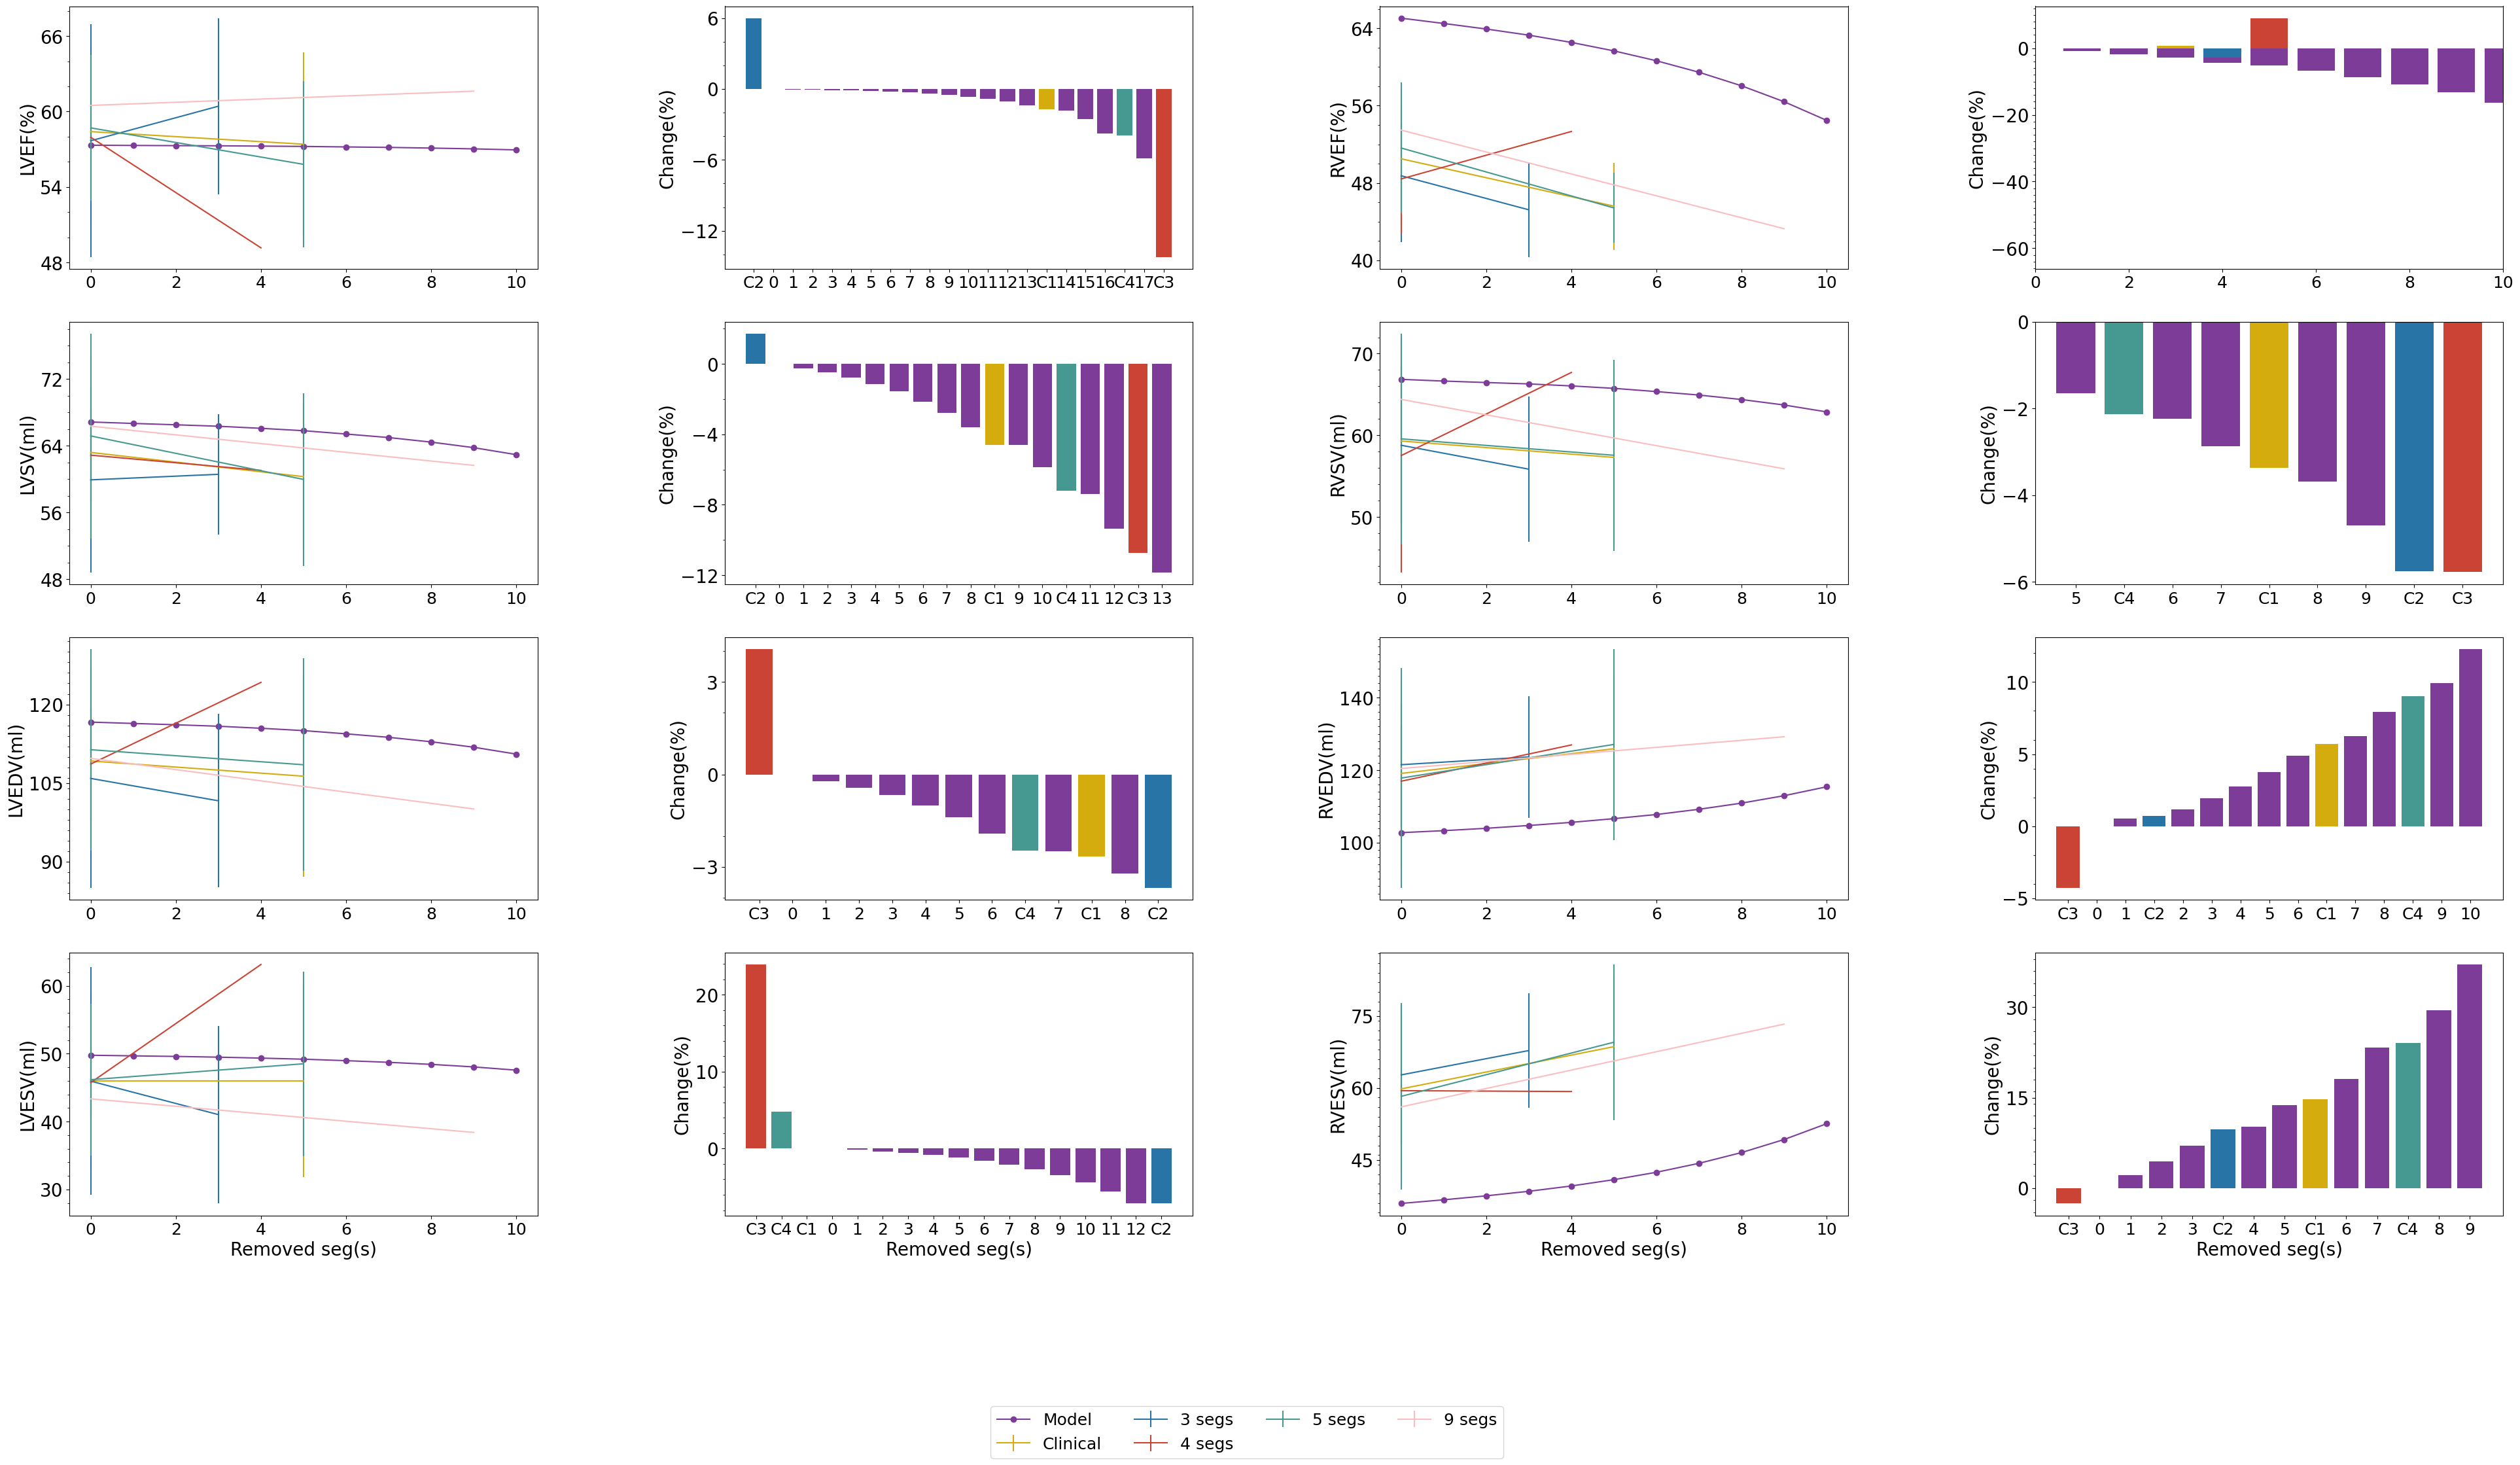

In [597]:
import matplotlib.ticker as ticker
original = '#7d3c98'
L1 = '#d4ac0d'
L2 = '#2874a6'
L3 = '#cb4335'
L4 = '#469990'
L5 = '#fabebe'
L6 = '#af601a'
L7 = '#5d6d7e'
color = [original, L1, L2, L3, L4, L5, L6, L7]
xaxis = range(0,18)
labels = [str(i) for i in range(len(xaxis))]
fontsize = 20
status = np.array(['Pre-op', 'Post-op'])
rvef_cl = np.array([50.5, 45.6])
rvef_err = np.array([6.9, 4.5])
fig, axs = plt.subplots(4, 4, figsize=(48, 24)) 
axs[0,2].plot(rm[0:11], rvef[0:11]*100, marker='o', linestyle='-', color=original, label='Model')
axs[0,2].set_ylabel('RVEF(%)', fontsize = fontsize)
axs[0,2].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[0,2].errorbar([0,5], rvef_cl, yerr = rvef_err ,color=L1, label = 'Clinical')
axs[0,2].errorbar([0,3], rvef_3m, yerr = rvef_3sd ,color=L2, label = '3 segs')
axs[0,2].errorbar([0,4], rvef_4m, yerr = rvef_4sd ,color=L3, label = '4 segs')
axs[0,2].errorbar([0,5], rvef_5m, yerr = rvef_5sd ,color=L4, label = '5 segs')
axs[0,2].errorbar([0,9], rvef_9m, yerr = rvef_9sd ,color=L5, label = '9 segs')
axs[0,2].legend()
err_rvef = err_cal(rvef)
rvef_st = [50.5, 45.6]
err_rvefst = err_cal(rvef_st)
bar(axs[0,3], color, err_rvef, loc = [3,4,5], value = [rvedv_3, rvedv_4, rvedv_5])

#rvedv_cl = [119.1, 125.9]
#rvedv_err = [25.4,22.5]

svrv_cl = [59.3, 57.3]
svrv_err = [12,10.7]

axs[1,2].plot(rm[0:11], sv_rv[0:11], marker='o', linestyle='-', color=original)
axs[1,2].set_ylabel('RVSV(ml)', fontsize = fontsize)
axs[1,2].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[1,2].errorbar([0, 5], svrv_cl, yerr = svrv_err ,color=L1)
axs[1,2].errorbar([0, 3], rvsv_3m, yerr = rvsv_3sd ,color=L2)
axs[1,2].errorbar([0, 4], rvsv_4m, yerr = rvsv_4sd ,color=L3)
axs[1,2].errorbar([0, 5], rvsv_5m, yerr = rvsv_5sd ,color=L4)
axs[1,2].errorbar([0, 9], rvsv_9m, yerr = rvsv_9sd ,color=L5)
err_svrv = err_cal(sv_rv)
err_svrvst = err_cal(svrv_cl)
bar_fig(axs[1,3], err_svrv, [L1,L2, L3, L4], err_svrvst[-1], rvsv_3,rvsv_4,rvsv_5)


rvedv_cl = [119.1, 125.9]
rvedv_err = [25.4, 20.5]

axs[2,2].plot(rm[0:11], rvedv[0:11], marker='o', linestyle='-', color=original)
axs[2,2].set_ylabel('RVEDV(ml)', fontsize = fontsize)
axs[2,2].errorbar([0,5], rvedv_cl, yerr = rvedv_err ,color=L1)
axs[2,2].errorbar([0,3], rvedv_3m, yerr = rvedv_3sd ,color=L2)
axs[2,2].errorbar([0,4], rvedv_4m, yerr = rvedv_4sd ,color=L3)
axs[2,2].errorbar([0,5], rvedv_5m, yerr = rvedv_5sd ,color=L4)
axs[2,2].errorbar([0,9], rvedv_9m, yerr = rvedv_9sd ,color=L5)
err_rvedv = err_cal(rvedv)
err_rvedvst = err_cal(rvedv_cl)
bar_fig(axs[2,3], err_rvedv, [L1,L2, L3, L4], err_rvedvst[-1], rvedv_3,rvedv_4,rvedv_5)

rvesv_cl = [59.8, 68.6]
rvesv_err = [17.1, 14.5]
axs[3,2].plot(rm[0:11], rvesv[0:11], marker='o', linestyle='-', color=original)
axs[3,2].set_ylabel('RVESV(ml)', fontsize = fontsize)

axs[3,2].errorbar([0,5], rvesv_cl, yerr = rvesv_err ,color=L1)
axs[3,2].errorbar([0,3], rvesv_3m, yerr = rvesv_3sd ,color=L2)
axs[3,2].errorbar([0,4], rvesv_4m, yerr = rvesv_4sd ,color=L3)
axs[3,2].errorbar([0,5], rvesv_5m, yerr = rvesv_5sd ,color=L4)
axs[3,2].errorbar([0,9], rvesv_9m, yerr = rvesv_9sd ,color=L5)
#ax_inset.set_ylim(80,170)

err_rvesv = err_cal(rvesv)
err_rvesvst = err_cal(rvesv_cl)
bar_fig(axs[3,3], err_rvesv, [L1,L2, L3, L4], err_rvesvst[-1], rvesv_3,rvesv_4,rvesv_5)
axs[3,2].set_xlabel('Removed seg(s)', fontsize = fontsize)
axs[3,3].set_xlabel('Removed seg(s)', fontsize = fontsize)
axs[1,3].set_ylabel('Change(%)', fontsize = fontsize)
axs[2,3].set_ylabel('Change(%)', fontsize = fontsize)
axs[3,3].set_ylabel('Change(%)', fontsize = fontsize)
axs[0,3].set_ylabel('Change(%)', fontsize = fontsize)

status = np.array(['Pre-op', 'Post-op'])
lvef_cl = np.array([58.4, 57.4])
lvef_err = np.array([7.1, 7.3])
axs[0,0].plot(rm[0:11], lvef[0:11]*100, marker='o', linestyle='-', color=original)
axs[0,0].set_ylabel('LVEF(%)', fontsize = fontsize)
axs[0,0].errorbar([0,5], lvef_cl, yerr = lvef_err ,color=L1)
axs[0,0].errorbar([0,3], lvef_3m, yerr = lvef_3sd ,color=L2)
axs[0,0].errorbar([0,4], lvef_4m, yerr = lvef_4sd ,color=L3)
axs[0,0].errorbar([0,5], lvef_5m, yerr = lvef_5sd ,color=L4)
axs[0,0].errorbar([0,9], lvef_9m, yerr = lvef_9sd ,color=L5)
err_lvef = err_cal(lvef)
err_lvefst = err_cal(lvef_cl)
bar_fig(axs[0, 1], err_lvef, [L1,L2, L3, L4], err_lvefst[-1], lvef_3, lvef_4, lvef_5)

#rvedv_cl = [119.1, 125.9]
#rvedv_err = [25.4,22.5]

svlv_cl = [63.2, 60.3]
svlv_err = [11.7,9]

axs[1,0].plot(rm[0:11], sv_lv[0:11], marker='o', linestyle='-', color=original)
axs[1,0].set_ylabel('LVSV(ml)', fontsize = fontsize)
axs[1,0].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[1,0].errorbar([0,5], svlv_cl, yerr = svlv_err ,color=L1)
axs[1,0].errorbar([0,3], lvsv_3m, yerr = lvsv_3sd ,color=L2)
axs[1,0].errorbar([0,4], lvsv_4m, yerr = lvsv_4sd ,color=L3)
axs[1,0].errorbar([0,5], lvsv_5m, yerr = lvsv_5sd ,color=L4)
axs[1,0].errorbar([0,9], lvsv_9m, yerr = lvsv_9sd ,color=L5)

err_svlv = err_cal(sv_lv)
err_svlvst = err_cal(svlv_cl)
bar_fig(axs[1,1], err_svlv, [L1,L2, L3, L4], err_svlvst[-1], lvsv_3,lvsv_4,lvsv_5)


lvedv_cl = [109.2, 106.3]
lvedv_err = [19.5, 19.2]

axs[2,0].plot(rm[0:11], lvedv[0:11], marker='o', linestyle='-', color=original)
axs[2,0].set_ylabel('LVEDV(ml)', fontsize = fontsize)
axs[2,0].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[2,0].errorbar([0,5], lvedv_cl, yerr = lvedv_err ,color=L1)
axs[2,0].errorbar([0,3], lvedv_3m, yerr = lvedv_3sd ,color=L2)
axs[2,0].errorbar([0,4], lvedv_4m, yerr = lvedv_4sd ,color=L3)
axs[2,0].errorbar([0,5], lvedv_5m, yerr = lvedv_5sd ,color=L4)
axs[2,0].errorbar([0,9], lvedv_9m, yerr = lvedv_9sd ,color=L5)

err_lvedv = err_cal(lvedv)
err_lvedvst = err_cal(lvedv_cl)
bar_fig(axs[2,1], err_lvedv, [L1,L2, L3, L4], err_lvedvst[-1], lvedv_3,lvedv_4,lvedv_5)

lvesv_cl = [46, 46]
lvesv_err = [13.2, 14.2]

axs[3,0].plot(rm[0:11], lvesv[0:11], marker='o', linestyle='-', color=original)
axs[3,0].set_ylabel('LVESV(ml)', fontsize = fontsize)
axs[3,0].errorbar([0,5], lvesv_cl, yerr = lvesv_err ,color=L1)
axs[3,0].errorbar([0,3], lvesv_3m, yerr = lvesv_3sd ,color=L2)
axs[3,0].errorbar([0,4], lvesv_4m, yerr = lvesv_4sd ,color=L3)
axs[3,0].errorbar([0,5], lvesv_5m, yerr = lvesv_5sd ,color=L4)
axs[3,0].errorbar([0,9], lvesv_9m, yerr = lvesv_9sd ,color=L5)
err_lvesv = err_cal(lvesv)
err_lvesvst = err_cal(lvesv_cl)
bar_fig(axs[3,1], err_lvesv, [L1,L2, L3, L4], err_lvesvst[-1], lvesv_3,lvesv_4,lvesv_5)

axs[3,0].set_xlabel('Removed seg(s)', fontsize = fontsize)
axs[3,1].set_xlabel('Removed seg(s)', fontsize = fontsize)
axs[1,1].set_ylabel('Change(%)', fontsize = fontsize)
axs[2,1].set_ylabel('Change(%)', fontsize = fontsize)
axs[3,1].set_ylabel('Change(%)', fontsize = fontsize)
axs[0,1].set_ylabel('Change(%)', fontsize = fontsize)
for ax in axs.flat:
    ax.tick_params(axis = 'x', labelsize = fontsize - 2)
    ax.tick_params(axis = 'y', labelsize = fontsize)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4,  integer=True))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))
for ax in axs[:, 0]:
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))
for ax in axs[:, 2]:
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))
for ax in axs.flat:
    ax.legend().set_visible(False)
fig.legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05), fontsize=18)
plt.subplots_adjust(wspace = 0.4)
plt.savefig('both_compare.svg', format='svg', bbox_inches='tight')
plt.savefig('both_compare.pdf', format='pdf', bbox_inches='tight')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


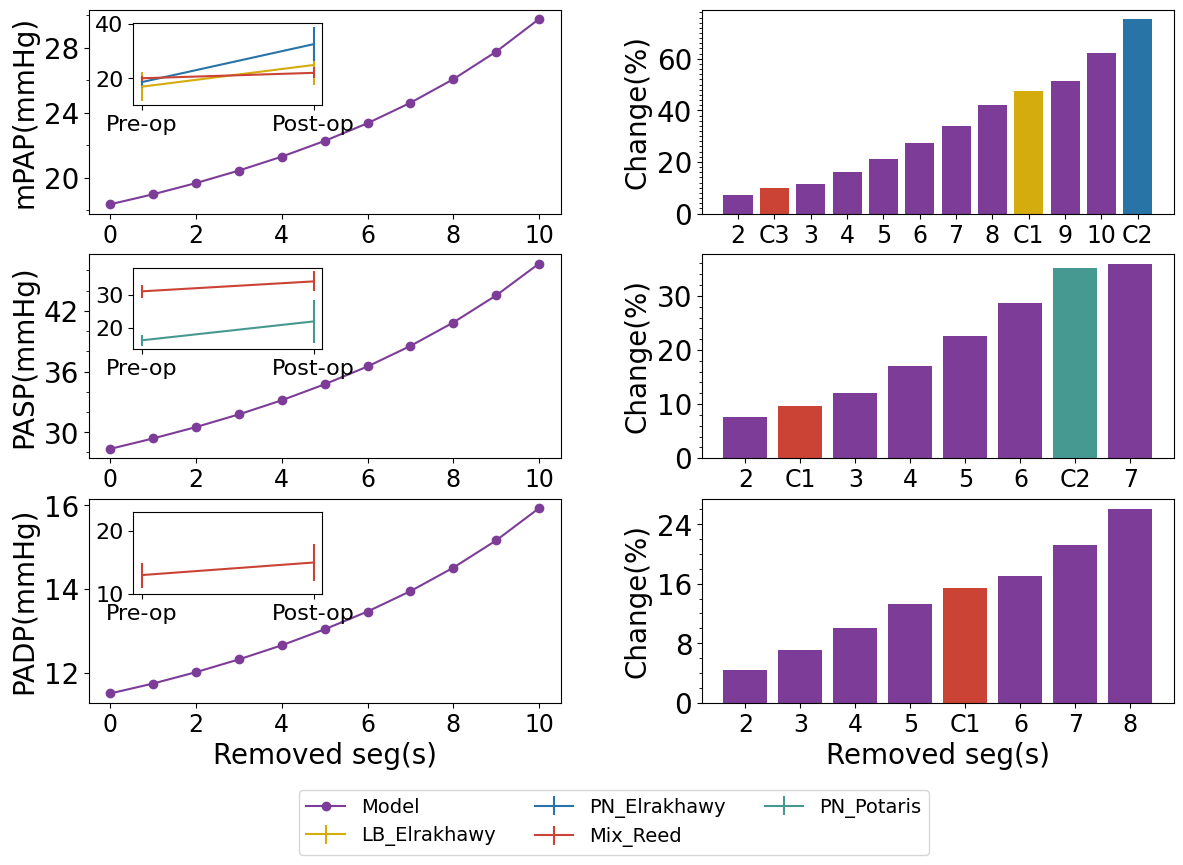

In [491]:
mpap = np.mean(p_pa, axis = 1)
mpap_elr_lb = [16.9, 24.9]
mpap_err_elr_lb = [5.3, 7.3]
mpap_elr_pn = [18.6, 32.6]
mpap_err_elr_pn = [2.2, 6.4]
fig, axs = plt.subplots(3, 2, figsize=(14, 9)) 
axs[0,0].plot(rm[0:11], mpap[0:11], marker='o', linestyle='-', color=original, label= 'Model')
axs[0,0].set_ylabel('mPAP(mmHg)')
axs[0,0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax_inset = inset_axes(axs[0,0], width="40%", height="40%", loc="lower left", bbox_to_anchor=(0.08, 0.5,1, 1), 
                      bbox_transform=axs[0,0].transAxes) 
ax_inset.errorbar(status, mpap_elr_lb, yerr = mpap_err_elr_lb ,color = L1, label = 'LB_Elrakhawy')
ax_inset.errorbar(status, mpap_elr_pn, yerr = mpap_err_elr_pn, color = L2, label = 'PN_Elrakhawy')
mpap_reed_lb = [20, 22]
mpap_err_reed_lb = [1, 2]
ax_inset.errorbar(status, mpap_reed_lb, yerr = mpap_err_reed_lb ,color = L3, label = 'Mix_Reed')
ax_inset.tick_params(axis = 'x', labelsize = fontsize - 4)
ax_inset.tick_params(axis = 'y', labelsize = fontsize - 4)
err_mpap = err_cal(mpap)
err_mpap_elr_lb = err_cal(mpap_elr_lb)
err_mpap_elr_pn = err_cal(mpap_elr_pn)
err_mpap_reed_lb = err_cal(mpap_reed_lb)
#bar_fig(axs[0, 1], err_mpap, err_mpapst_lb[-1])
bar_fig(axs[0, 1], err_mpap, [L1,L2,L3], err_mpap_elr_lb[-1], err_mpap_elr_pn[-1], err_mpap_reed_lb[-1])#L1: lobe, L2: Pn, L3:LB
axs[0,1].yaxis.set_major_locator(MaxNLocator(integer=True))


pap_reed_s = [31, 34]
pap_reed_s_err = [2,3]

axs[1, 0].plot(rm[0:11], paps[0:11], marker='o', linestyle='-', color=original)
axs[1, 0].set_ylabel('PASP(mmHg)')
axs[1, 0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax_inset = inset_axes(axs[1, 0], width="40%", height="40%", loc="lower left", bbox_to_anchor=(0.08, 0.5,1, 1), 
                      bbox_transform=axs[1, 0].transAxes) 
ax_inset.errorbar(status, pap_reed_s, yerr = pap_reed_s_err ,color = L3)
ax_inset.tick_params(axis = 'x', labelsize = fontsize - 4)
ax_inset.tick_params(axis = 'y', labelsize = fontsize - 4)
pap_potar_s = [16.22, 21.91]
pap_potar_err = [1.6, 6.6]
ax_inset.errorbar(status, pap_potar_s, pap_potar_err, color = L4, label = 'PN_Potaris')
err_pasp = err_cal(paps)
err_pasp_reed_lb = err_cal(pap_reed_s)
err_pasp_potaris_pn = err_cal(pap_potar_s)
bar_fig(axs[1, 1], err_pasp, [L3, L4], err_pasp_reed_lb[-1], err_pasp_potaris_pn[-1])
plt.subplots_adjust(wspace=0.4)
axs[1, 0].set_ylabel('PASP(mmHg)')
axs[1, 1].set_ylabel('Change(%)')

pap_reed_d = [13, 15]
pap_reed_d_err = [1,1]

axs[2, 0].plot(rm[0:11], papd[0:11], marker='o', linestyle='-', color=original)
axs[2, 0].set_ylabel('PADP(mmHg)')
axs[2, 0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax_inset = inset_axes(axs[2, 0], width="40%", height="40%", loc="lower left", bbox_to_anchor=(0.08, 0.5,1, 1), 
                      bbox_transform=axs[2, 0].transAxes) 
ax_inset.errorbar(status, pap_reed_d, yerr = pap_reed_s_err ,color = L3)
ax_inset.tick_params(axis = 'x', labelsize = fontsize - 4)
ax_inset.tick_params(axis = 'y', labelsize = fontsize - 4)
ax_inset.set_ylim(10,23)
err_padp = err_cal(papd)
err_padpst_lb = err_cal(pap_reed_d)
bar_fig(axs[2, 1], err_padp, [L3], err_padpst_lb[-1])
#mean: 5.46667
plt.subplots_adjust(wspace=0.4)
axs[2, 1].set_ylabel('Change(%)')
axs[2, 0].set_xlabel('Removed seg(s)')
axs[2, 1].set_xlabel('Removed seg(s)')
axs[0, 1].set_ylabel('Change(%)')
for ax in axs.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=fontsize)
    ax.set_ylabel(ax.get_ylabel(), fontsize=fontsize)
    ax.tick_params(axis = 'x', labelsize = fontsize - 3)
    ax.tick_params(axis = 'y', labelsize = fontsize)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4,  integer=True))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))
for ax in axs[:, 0]:
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))
for ax in axs.flat:
    ax.legend().set_visible(False)
fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.07), fontsize=14)
plt.subplots_adjust(wspace = 0.3)
plt.savefig('PA_compare.svg', format='svg', bbox_inches='tight')
plt.show()

## RVSP

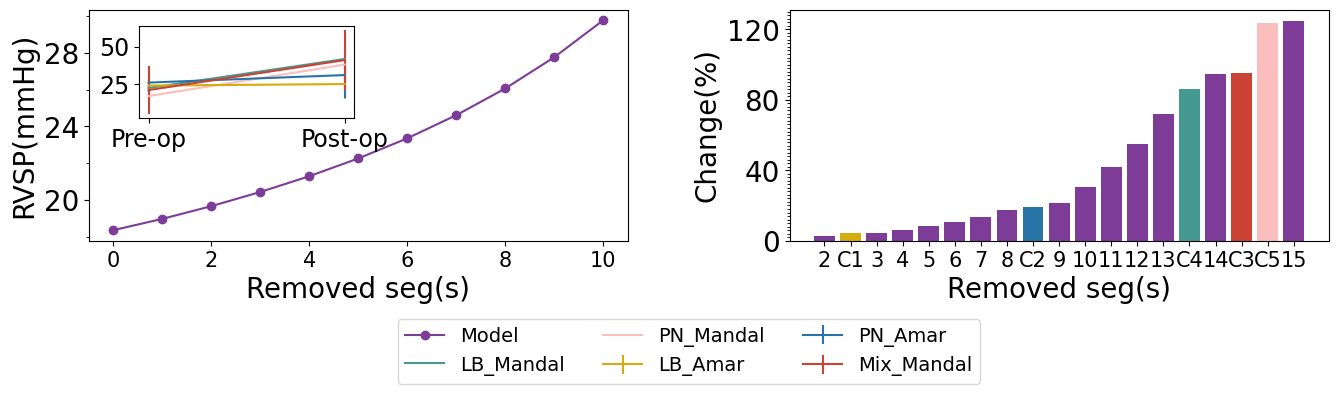

In [492]:
fig, axs = plt.subplots(1, 2, figsize=(16, 3)) 

rvsp_amar_lb = [24, 25]
rvsp_err_amar_lb = [6, 10]
rvsp_amar_pn = [26, 31]
rvsp_err_amar_pn = [11, 15]
rvsp_mandal_mix = [21, 41]
rvsp_mandal_err_mix = [16, 20]
rvsp_mandal_pn = [17, 38]
rvsp_mandal_lb = [22.4, 41.7]

axs[0].plot(rm[0:11], mpap[0:11], marker='o', linestyle='-', color=original, label='Model')
axs[0].set_ylabel('RVSP')
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax_inset = inset_axes(axs[0], width="40%", height="40%", loc="lower left", bbox_to_anchor=(0.08, 0.5,1, 1), 
                      bbox_transform=axs[0].transAxes) 
ax_inset.errorbar(status, rvsp_amar_lb, yerr = rvsp_err_amar_lb ,color = L1, label = 'LB_Amar')
ax_inset.errorbar(status, rvsp_amar_pn, yerr = rvsp_err_amar_pn ,color = L2, label = 'PN_Amar')
ax_inset.errorbar(status, rvsp_mandal_mix, yerr = rvsp_mandal_err_mix ,color = L3, label = 'Mix_Mandal')
ax_inset.plot(status, rvsp_mandal_lb,color = L4, label = 'LB_Mandal')
ax_inset.plot(status, rvsp_mandal_pn,color = L5, label = 'PN_Mandal')
ax_inset.tick_params(axis = 'x', labelsize = fontsize-3)
ax_inset.tick_params(axis = 'y', labelsize = fontsize-3)
err_rvsp = err_cal(rvsp)
err_rvspamar_lb = err_cal(rvsp_amar_lb)
err_rvspamar_pn = err_cal(rvsp_amar_pn)
err_rvspmandal_mix = err_cal(rvsp_mandal_mix)
err_rvspmandal_lb = err_cal(rvsp_mandal_lb)
err_rvspmandal_pn = err_cal(rvsp_mandal_pn)
bar_fig(axs[1], err_rvsp, [L1,L2,L3,L4,L5], err_rvspamar_lb[-1], err_rvspamar_pn[-1], err_rvspmandal_mix[-1], err_rvspmandal_lb[-1], err_rvspmandal_pn[-1])

plt.subplots_adjust(wspace=0.4)
axs[0].set_ylabel('RVSP(mmHg)')
axs[1].set_ylabel('Change(%)')
axs[0].set_xlabel('Removed seg(s)')
axs[1].set_xlabel('Removed seg(s)')
for ax in axs.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=fontsize)
    ax.set_ylabel(ax.get_ylabel(), fontsize=fontsize)
    ax.tick_params(axis = 'x', labelsize = fontsize - 5)
    ax.tick_params(axis = 'y', labelsize = fontsize)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4,  integer=True))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))
fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.4), fontsize=14)
axs[0].legend().set_visible(False)
plt.subplots_adjust(wspace = 0.3)
plt.savefig('RVSP_compare.svg', format='svg', bbox_inches='tight')
plt.savefig('RVSP_compare.pdf', format='pdf', bbox_inches='tight')

## RV

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

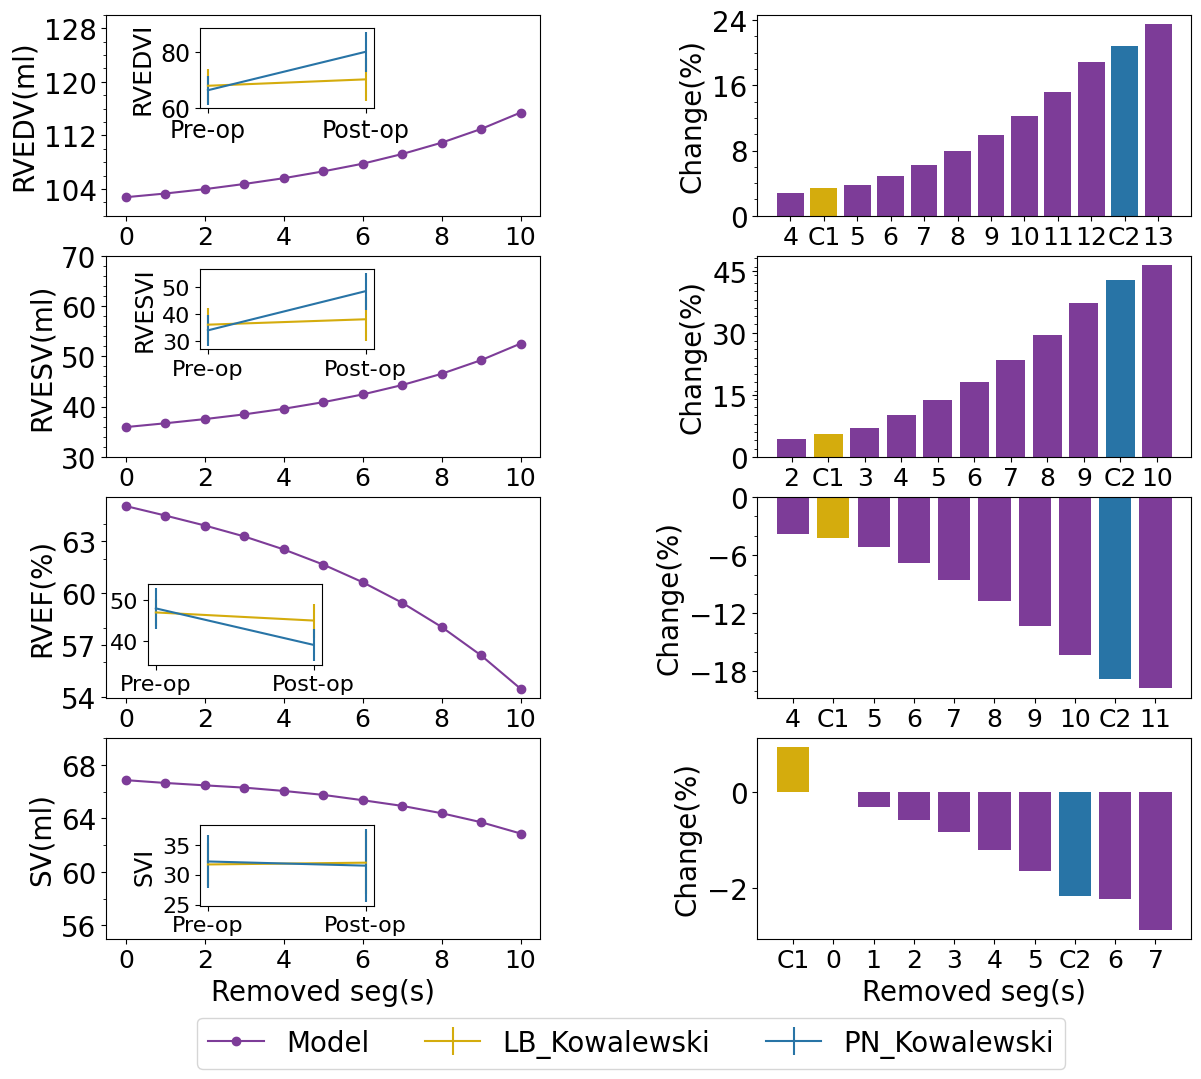

In [493]:
# Kowalewski
fig, axs = plt.subplots(4, 2, figsize=(14, 12)) 
####RVEDVI
rvedvi_cl_pn = [66.2, 80]
rvedvi_err_pn = [5.2, 7.2]
rvedvi_cl_lb = [67.8, 70.1]
rvedvi_err_lb = [6.1, 7.8]

axs[0,0].plot(rm[0:11], rvedv[0:11], marker='o', linestyle='-', color=original, label = 'Model')
axs[0,0].set_ylabel('RVEDV(ml)')
axs[0,0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax_inset = inset_axes(axs[0,0], width="40%", height="40%", loc="lower left", bbox_to_anchor=(0.2, 0.5,1, 1), 
                      bbox_transform=axs[0,0].transAxes) 
ax_inset.errorbar(status, rvedvi_cl_lb, yerr = rvedvi_err_lb ,color = L1, label = 'LB_Kowalewski')
ax_inset.errorbar(status, rvedvi_cl_pn, yerr = rvedvi_err_pn ,color = L2, label = 'PN_Kowalewski')
ax_inset.set_ylabel('RVEDVI', fontsize = fontsize-2)
ax_inset.tick_params(axis = 'x', labelsize = fontsize - 3)
ax_inset.tick_params(axis = 'y', labelsize = fontsize -3)
err_rvedv = err_cal(rvedv)
err_rvedvist_lb = err_cal(rvedvi_cl_lb)
err_rvedvist_pn = err_cal(rvedvi_cl_pn)
bar_fig(axs[0,1], err_rvedv, [L1, L2], err_rvedvist_lb[-1], err_rvedvist_pn[-1])

rvesvi_cl_pn = [34, 48.5]
rvesvi_err_pn = [5.7, 6.8]
rvesvi_cl_lb = [36.1, 38.1]
rvesvi_err_lb = [6.2, 8.2]

axs[1,0].plot(rm[0:11], rvesv[0:11], marker='o', linestyle='-', color=original)
axs[1,0].set_ylabel('RVESV(ml)')
axs[1,0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax_inset = inset_axes(axs[1,0], width="40%", height="40%", loc="lower left", bbox_to_anchor=(0.2, 0.5,1, 1), 
                      bbox_transform=axs[1,0].transAxes) 
ax_inset.errorbar(status, rvesvi_cl_lb, yerr = rvesvi_err_lb ,color = L1)
ax_inset.errorbar(status, rvesvi_cl_pn, yerr = rvesvi_err_pn ,color = L2)
ax_inset.set_ylabel('RVESVI', fontsize = fontsize - 3)
ax_inset.tick_params(axis = 'x', labelsize = fontsize - 4)
ax_inset.tick_params(axis = 'y', labelsize = fontsize -4)
err_rvesv = err_cal(rvesv)
err_rvesvist_lb = err_cal(rvesvi_cl_lb)
err_rvesvist_pn = err_cal(rvesvi_cl_pn)
bar_fig(axs[1,1], err_rvesv, [L1, L2],err_rvesvist_lb[-1], err_rvesvist_pn[-1])

rvef_cl_pn = [48, 39]
rvef_err_pn = [5, 4]
rvef_cl_lb = [47, 45]
rvef_err_lb = [3.4, 4.2]

axs[2,0].plot(rm[0:11], rvef[0:11]*100, marker='o', linestyle='-', color=original)
axs[2,0].set_ylabel('RVEF(%)')
axs[2,0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax_inset = inset_axes(axs[2,0], width="40%", height="40%", loc="lower left", bbox_to_anchor=(0.08, 0.13,1, 1), 
                      bbox_transform=axs[2,0].transAxes) 
ax_inset.errorbar(status, rvef_cl_lb, yerr = rvef_err_lb ,color = L1)
ax_inset.errorbar(status, rvef_cl_pn, yerr = rvef_err_pn ,color = L2)
ax_inset.tick_params(axis = 'x', labelsize = fontsize - 4)
ax_inset.tick_params(axis = 'y', labelsize = fontsize -4)
err_rvef = err_cal(rvef)
err_rvefst_lb = err_cal(rvef_cl_lb)
err_rvefst_pn = err_cal(rvef_cl_pn)
bar_fig(axs[2,1], err_rvef, [L1, L2], err_rvefst_lb[-1], err_rvefst_pn[-1])

rvsv_cl_pn = [32.2, 31.5]
rvsv_err_pn = [4.4, 6.1]
rvsv_cl_lb = [31.7, 32]
rvsv_err_lb = [3.6, 5.3]

axs[3,0].plot(rm[0:11], sv_rv[0:11], marker='o', linestyle='-', color=original)
axs[3,0].set_ylabel('SV(ml)')
axs[3,0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax_inset = inset_axes(axs[3,0], width="40%", height="40%", loc="lower left", bbox_to_anchor=(0.2, 0.13,1, 1), 
                      bbox_transform=axs[3,0].transAxes) 
ax_inset.errorbar(status, rvsv_cl_lb, yerr = rvsv_err_lb ,color = L1)
ax_inset.errorbar(status, rvsv_cl_pn, yerr = rvsv_err_pn ,color = L2)
ax_inset.set_ylabel('SVI', fontsize = fontsize -3)
ax_inset.tick_params(axis = 'x', labelsize = fontsize - 4)
ax_inset.tick_params(axis = 'y', labelsize = fontsize -4)
err_rvsv = err_cal(sv_rv)
err_rvsvst_lb = err_cal(rvsv_cl_lb)
err_rvsvst_pn = err_cal(rvsv_cl_pn)
bar_fig(axs[3,1], err_rvsv, [L1, L2], err_rvsvst_lb[-1], err_rvsvst_pn[-1])
plt.subplots_adjust(wspace=0.4)
axs[0,1].set_ylabel('Change(%)')
axs[1,1].set_ylabel('Change(%)')
axs[2,1].set_ylabel('Change(%)')
axs[3,1].set_ylabel('Change(%)')
axs[3,0].set_xlabel('Removed seg(s)')
axs[3,1].set_xlabel('Removed seg(s)')
axs[0,0].set_ylim(100,130)
axs[1,0].set_ylim(30,70)
axs[3,0].set_ylim(55,70)
for ax in axs.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=fontsize)
    ax.set_ylabel(ax.get_ylabel(), fontsize=fontsize)
    ax.tick_params(axis = 'x', labelsize = fontsize - 2)
    ax.tick_params(axis = 'y', labelsize = fontsize)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4,  integer=True))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))
for ax in axs[:, 0]:
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))
for ax in axs.flat:
    ax.legend().set_visible(False)
fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.01), fontsize=20)
plt.subplots_adjust(wspace = 0.5)
plt.savefig('RV_compare.svg', format='svg', bbox_inches='tight')
plt.savefig('RV_compare.pdf', format='pdf', bbox_inches='tight')
plt.show()

## LVEF

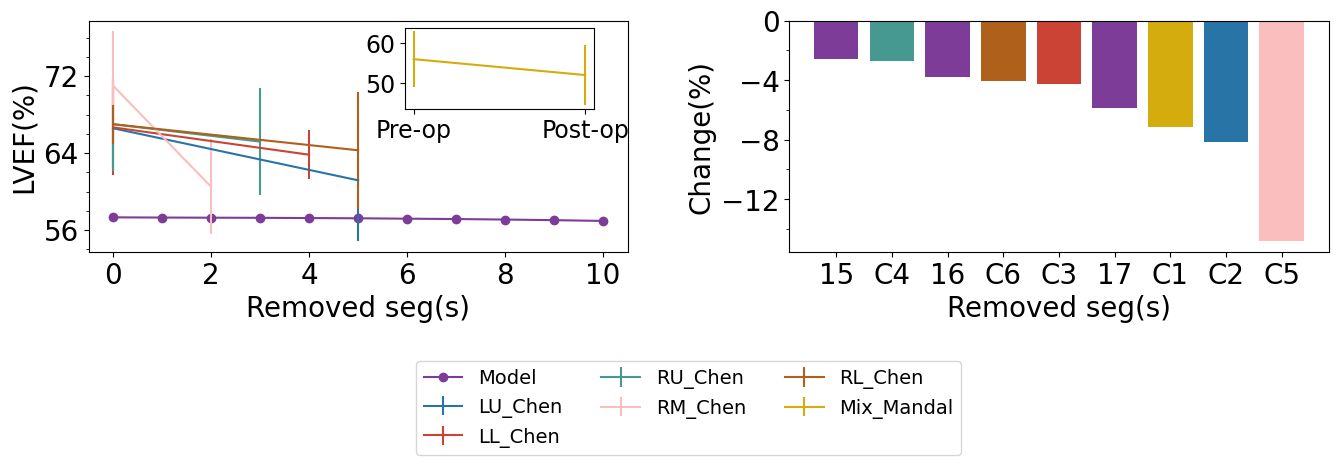

In [494]:
fig, axs = plt.subplots(1, 2, figsize=(16, 3)) 
lvef_mandal_mix = [56, 52]
lvef_err_mandal_mix = [7, 7.5]
lvef_chen_lu = [66.58, 61.17]
lvef_chen_err_lu = [4.12, 6.33]

lvef_chen_ll = [66.67, 63.83]
lvef_chen_err_ll = [4.93, 2.56]

lvef_chen_ru = [67, 65.19]
lvef_chen_err_ru = [4.87, 5.54]

lvef_chen_rm = [71, 60.5]
lvef_chen_err_rm = [5.66, 4.95]

lvef_chen_rl = [67, 64.29]
lvef_chen_err_rl = [2.02, 6.08]

axs[0].plot(rm[0:11], lvef[0:11]*100, marker='o', linestyle='-', color=original, label='Model')
axs[0].errorbar([0,5], lvef_chen_lu, yerr = lvef_chen_err_lu, color = L2, label = 'LU_Chen')
axs[0].errorbar([0,4], lvef_chen_ll, yerr = lvef_chen_err_ll, color = L3, label = 'LL_Chen')
axs[0].errorbar([0,3], lvef_chen_ru, yerr = lvef_chen_err_ru, color = L4, label = 'RU_Chen')
axs[0].errorbar([0,2], lvef_chen_rm, yerr = lvef_chen_err_rm, color = L5, label = 'RM_Chen')
axs[0].errorbar([0,5], lvef_chen_rl, yerr = lvef_chen_err_rl, color = L6, label = 'RL_Chen')
axs[0].set_ylabel('LVEF(%)')
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax_inset = inset_axes(axs[0], width="35%", height="35%", loc="upper right", bbox_to_anchor=(-0.05, 0,1, 1), 
                      bbox_transform=axs[0].transAxes) 
ax_inset.errorbar(status, lvef_mandal_mix , yerr = lvef_err_mandal_mix  ,color = L1, label = 'Mix_Mandal')
err_lvef = err_cal(lvef)
err_lvef_mandal_mix = err_cal(lvef_mandal_mix)
err_lvef_chen_lu = err_cal(lvef_chen_lu)
err_lvef_chen_ll = err_cal(lvef_chen_ll)
err_lvef_chen_ru = err_cal(lvef_chen_ru)
err_lvef_chen_rm = err_cal(lvef_chen_rm)
err_lvef_chen_rl = err_cal(lvef_chen_rl)
bar_fig(axs[1], err_lvef, [L1, L2,L3,L4,L5,L6],err_lvef_mandal_mix[-1], err_lvef_chen_lu[-1], err_lvef_chen_ll[-1], err_lvef_chen_ru[-1], err_lvef_chen_rm[-1], err_lvef_chen_rl[-1])
plt.subplots_adjust(wspace=0.4)
axs[1].set_ylabel('Change(%)')
axs[0].set_xlabel('Removed seg(s)')
axs[1].set_xlabel('Removed seg(s)')
for ax in axs.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=fontsize)
    ax.set_ylabel(ax.get_ylabel(), fontsize=fontsize)
    ax.tick_params(axis = 'x', labelsize = fontsize)
    ax.tick_params(axis = 'y', labelsize = fontsize)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4,  integer=True))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))
fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.6), fontsize=14)
ax_inset.tick_params(axis = 'x', labelsize = fontsize-3)
ax_inset.tick_params(axis = 'y', labelsize = fontsize-3)
axs[0].legend().set_visible(False)
plt.subplots_adjust(wspace = 0.3)
plt.savefig('LVEF_compare.svg', format='svg', bbox_inches='tight')
plt.savefig('LVEF_compare.pdf', format='pdf', bbox_inches='tight')